# HackerEarth Machine Learning : solving citizens’ grievances

### Predict the importance

Human rights are basic rights that belong to people all around the world irrespective of race, color, sex, language, religion, political or other opinions, national or social origin, property, birth, etc. These rights include the right to life and liberty, freedom from slavery and torture, freedom of opinion and expression, the right to work and education, etc. It is meant to enable human beings to live with dignity, freedom, equality, justice, and peace. Human rights are essential to the full development of individuals and communities.

**In this problem, given dataset contains grievances of various people living in a country. Task is to predict the importance of the grievance with respect to various articles, constitutional declarations, enforcement, resources, and so on, to help the government prioritize which ones to deal with and when.**

### Data description
The dataset folder consists of the following three .csv files:

train.csv: Contains 8878 rows and 328 columns <br>
test.csv: Contains 4760 rows and 327 columns <br>
sample_submission.csv: 5 rows and 2 columns <br>

In [1]:
# Import pandas, numpy, matplotlib, seaborn libraries
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from tabulate import tabulate

# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2

# hide ipykernel warnings 
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False
%matplotlib inline

<br>

# Exploratory Data Analysis
* **In this section, data is explored for its cardinality, null values, duplicates, target class distribution etc.**
* To consider differences between train and test data [such as duplicates features, null features etc.]:
    * EDA is performed on whole data. So, train and test data is combined for EDA
    * **However, *Preprocessing* and *Prediction Model Training* is done ONLY ON TRAIN DATA**

## Data ingestion
Read train and test datasets

### Read train data
check data features and size of train data

In [2]:
# read in data from train.csv file to pandas dataframe.
df_train = pd.read_csv('dataset/train.csv',  keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)

In [3]:
df_train.head(2)

,appno,application,country.alpha2,country.name,decisiondate,docname,doctypebranch,ecli,introductiondate,issue.0,...,ccl_article=6,ccl_article=7,ccl_article=8,ccl_article=9,ccl_article=p1,ccl_article=p12,ccl_article=p4,ccl_article=p6,ccl_article=p7,importance
0,2052/08,MS WORD,ru,Russian Federation,NaN,CASE OF KOKOSHKINA v. RUSSIA,CHAMBER,ECLI:CE:ECHR:2009:0528JUD000205208,NaN,NaN,...,0,0,0,0,0,0,0,0,0,4
1,4728/07,MS WORD,tr,Turkey,NaN,CASE OF ÖZCAN v. TURKEY,COMMITTEE,ECLI:CE:ECHR:2018:0710JUD000472807,NaN,NaN,...,0,0,0,0,0,0,0,0,0,4


In [4]:
df_train.shape

(8878, 328)

### Check target class balance
* Target class 'importance' has 4 unique values
* Class distribution is imbalanced and skewed towards low importance cases 

<AxesSubplot:>

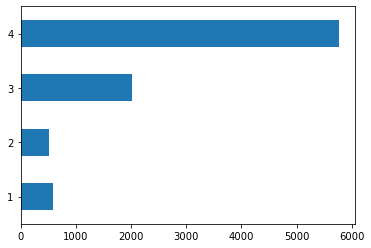

In [5]:
df_train['importance'].value_counts().plot(kind='barh')

### Read test data
Check data features and size of test data

In [6]:
# read in data from test.csv file to pandas dataframe.
df_test = pd.read_csv('dataset/test.csv',  keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)

In [7]:
df_test.head(2)

,appno,application,country.alpha2,country.name,decisiondate,docname,doctypebranch,ecli,introductiondate,issue.0,...,ccl_article=5,ccl_article=6,ccl_article=7,ccl_article=8,ccl_article=9,ccl_article=p1,ccl_article=p12,ccl_article=p4,ccl_article=p6,ccl_article=p7
0,1194/04,MS WORD,mk,North Macedonia,NaN,"CASE OF CAMINSKI v. ""THE FORMER YUGOSLAV REPUB...",COMMITTEE,ECLI:CE:ECHR:2011:0224JUD000119404,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
1,53865/11,MS WORD,ua,Ukraine,NaN,CASE OF KUSHCH v. UKRAINE,CHAMBER,ECLI:CE:ECHR:2015:1203JUD005386511,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


In [8]:
df_test.shape

(4760, 327)

## Concat train and test data to form complete dataset for EDA
* **Concat train and test data to perform EDA**
* **Drop target variable *'importance'* from train data to match number of features in both dataframes**

In [9]:
df = pd.concat([df_train.drop('importance', axis=1), df_test])

In [10]:
df.head(2)

,appno,application,country.alpha2,country.name,decisiondate,docname,doctypebranch,ecli,introductiondate,issue.0,...,ccl_article=5,ccl_article=6,ccl_article=7,ccl_article=8,ccl_article=9,ccl_article=p1,ccl_article=p12,ccl_article=p4,ccl_article=p6,ccl_article=p7
0,2052/08,MS WORD,ru,Russian Federation,NaN,CASE OF KOKOSHKINA v. RUSSIA,CHAMBER,ECLI:CE:ECHR:2009:0528JUD000205208,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
1,4728/07,MS WORD,tr,Turkey,NaN,CASE OF ÖZCAN v. TURKEY,COMMITTEE,ECLI:CE:ECHR:2018:0710JUD000472807,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


In [11]:
df.shape

(13638, 327)

### Count of Unique and null instances in features
We can locate primary key features of dataframe : **'ecli', 'itemid'**

In [12]:
null_samples = df.isna().sum()
null_data = np.array(
    [list(null_samples.index),
     list(str(df[i].unique()[-1])[:20]+",..." for i in df.columns),
     list(df.nunique().values),
     list(null_samples.values),
     np.round(np.array(null_samples.values)*100/df.shape[0], 2)
    ]
)
print(tabulate(pd.DataFrame(null_data).T, headers=["Feature", "example", "count unique\nvalues", "null samples",  "% null samples"], 
               showindex="never"), "\n\n\n")

Feature                            example                     count unique    null samples    % null samples
                                                                     values
---------------------------------  ------------------------  --------------  --------------  ----------------
appno                              21155/18,...                       13467               0              0
application                        MS WORD,...                            1               0              0
country.alpha2                     ad,...                                46               0              0
country.name                       Andorra,...                           46               0              0
decisiondate                       20/02/2007,...                       274           12603             92.41
docname                            CASE OF VOGLREITER v,...           13201               0              0
doctypebranch                      GRANDCHAMBER,...        

### find duplicate samples or features in dataset

**duplicate samples are NOT found**

In [13]:
# Check for duplicate rows
#Print the number of duplicate rows, without the original rows that were duplicated

# Check for duplicate rows for primary key "Animal ID"
print('Number of duplicate (excluding first) rows in the table is: ', df.duplicated(subset = "ecli").sum()) 

# Use "keep=False" to mark all duplicates as true, including the original rows that were duplicated.
print('Number of duplicate rows (including first) in the table is:', df[df.duplicated(subset = "ecli",keep=False)].shape[0])


Number of duplicate (excluding first) rows in the table is:  0
Number of duplicate rows (including first) in the table is: 0


**50 duplicate features are FOUND**

In [14]:
# Check for duplicate columns
#First transpose the df so columns become rows, then apply the same check as above
dfT = df.T

# Check for duplicate columns.
print("Number of duplicate (excluding first) columns in the table is: ", dfT.duplicated().sum())

#Print the number of duplicates, including the original columns that were duplicated
print("Number of duplicate (including first) columns in the table is: ",  dfT[dfT.duplicated(keep=False)].shape[0])

Number of duplicate (excluding first) columns in the table is:  50
Number of duplicate (including first) columns in the table is:  97


**Result : Duplicate columns (features) do exist**
 - **data samples** : Duplicate samples do not exist. Feature **ecli** has 13638 unique values - which is equal to number of data entries. Logically, its a primary key for the dataset. Hence, duplicacies are checked with its respect and none are found.
 - **features** : Total 97 features are invoved in duplicate entries and 50 features are duplicates of another 47 distinct features. Visualization in following cell helps to check out relations. 

### Locate Duplicate Features

In [15]:
retained_columns = dfT.drop_duplicates(keep="first").T.columns.values
duplicate_columns = list(set(list(df.columns)) - set(retained_columns))
print("duplicate columns",duplicate_columns)

duplicate columns ['paragraphs=19', 'paragraphs=6', 'paragraphs=27', 'paragraphs=33', 'paragraphs=16', 'applicability=15', 'paragraphs=7', 'paragraphs=P12-1', 'paragraphs=41', 'documentcollectionid=ENG', 'paragraphs=46', 'paragraphs=11', 'paragraphs=12', 'paragraphs=15', 'paragraphs=53', 'paragraphs=18', 'paragraphs=37', 'paragraphs=36', 'paragraphs=29', 'documentcollectionid=JUDGMENTS', 'paragraphs=9', 'kpdate', 'paragraphs=', 'paragraphs=1', 'paragraphs=39', 'paragraphs=43', 'paragraphs=P13-1', 'paragraphs=38', 'paragraphs=56', 'paragraphs=4', 'paragraphs=57', 'paragraphs=26', 'paragraphs=5', 'paragraphs=2', 'paragraphs=17', 'applicability=29', 'paragraphs=28', 'paragraphs=P7-1-1', 'paragraphs=34', 'paragraphs=35', 'paragraphs=52', 'paragraphs=25', 'paragraphs=30', 'paragraphs=8', 'paragraphs=14', 'paragraphs=3', 'paragraphs=10', 'applicability=31', 'paragraphs=32', 'paragraphs=13']


## Correlations

### Convert datatypes
* Categorical variables are retained as objects
* Integer and one hot encoded cat variables are inferred as 'int' types

In [16]:
# maintain object dtype as 'object' only
df = df.convert_dtypes(convert_string=False)

# view data types after conversion   
print(tabulate(pd.DataFrame(df.dtypes), headers=["Feature", "Data Type"]), "\n")

Feature                            Data Type
---------------------------------  -----------
appno                              object
application                        object
country.alpha2                     object
country.name                       object
decisiondate                       object
docname                            object
doctypebranch                      object
ecli                               object
introductiondate                   object
issue.0                            object
issue.1                            object
issue.10                           object
issue.11                           object
issue.12                           object
issue.13                           object
issue.14                           object
issue.15                           object
issue.16                           object
issue.17                           object
issue.18                           object
issue.19                           object
issue.2                   

<br>

# Data Quality Plan

### Observations from data
* **Few features are provided in 1 hot encoded format** : issue.{0-26}, article={27 nos}, applicability={61 nos}, ccl_article={25 nos}, paragraphs={132 nos}

### Action items
* **Drop confirm duplicate columns noticed on merged data**

### Analysis

* **NO_SIG** : Not significant towards prediction of target variable 'importance'
* **SIG** : Probable candidate feature to contribute in prediction of target variable 'importance'
* **HCR** : Very high Correlation with another feature
* **Keep** : KEEP feature
* **Drop** : DROP feature

| Features                  | Data<br>Classification| Subtype    | Description Or<br>domain significance  | Data quality issue |Solution Strategy |
|:------------------------- |:------------------ |:---------- |:-----------|:-------------- |:-------------- | 
| appno                                 | catagorical        | nominal    | application number<br><br>e.g. 53865/11|**NO_SIG**<br>13467 unique values<br>No nulls|**Drop**<br>|
| application                           | catagorical        | nominal    | software used<br><br>for lodging complaint<br>e.g. MS word|**NO_SIG**<br>1 unique value<br>no null|**Drop**<br>|
| country.alpha2                        | catagorical        | nominal    | country code<br><br>e.g. ie|**SIG**<br>46 unique countries<br>no nulls|**Keep**<br>|
| country.name                          | catagorical        | nominal    | country name<br><br>e.g. Ireland|**HCR**<br>Corr->1 with<br>'country.alpha2'|**Drop**<br>|
| decisiondate                          | numeric            | continuous<br>datetime   | date of decision|**NO_SIG**<br>92% null values|**Drop**<br>|
| docname                               | catagorical        | nominal    | name of case<br><br>e.g.CASE OF <br>EMINBEYLI v. RUSSIA|**NO_SIG**<br>name of complainant <br>and country available <br>in features 'country.name' <br>and 'parties.0'|**Drop**<br>|
| doctypebranch                         | catagorical        | Ordinal    | type of case<br><br>e.g. CHEMBER, COMMITTEE,<br>GRANDCHEMBER|**SIG**<br>represented in 1-hot<br>encoded form<br>in feature<br>'documentcollectionid=<br>{CHEMBER, COMMITTEE,<br>GRANDCHEMBER}'|**Drop**<br>|
| ecli                                  | catagorical        | nominal    | database case ID<br><br>e.g. ECLI:CE:ECHR:2015:<br>.1203JUD005386511|**NO_SIG**<br>primary key<br>no contribution<br>in prediction|**Drop**<br>|
| introductiondate                      | numeric            | continuous<br>datetime   | date of introduction|**NO_SIG**<br>92% null values|**Drop**<br>|
| itemid                                | catagorical        | nominal    | database item ID<br><br>e.g. 001-108659|**NO_SIG**<br>primary key<br>no contribution<br>in prediction|**Drop**<br>|
| judgementdate                         | numeric            | continuous<br>datetime   | date of Judgement|**SIG**<br>No null values<br>2088 unique<br>entries in<br>13638 samples|**Keep**<br><br>seperate into quarter, month, year, weekday|
| kpdate                                | numeric            | continuous<br>datetime   | date of closure|**SIG**<br>No null values<br>2088 unique<br>entries in<br>13638 samples|**Drop**<br>Duplicate of judgementdate|
| languageisocode                       | catagorical        | nominal    | Language<br><br>e.g. ENG|**NO_SIG**<br>1 unique value<br>no null|**Drop**<br>|
| originatingbody                       | catagorical        | nominal    | Party originating<br>case<br><br>e.g. [29,1..]|**SIG**<br>13 unique value<br>no null|**Keep**<br><br>typecast as categorical|
| originatingbody_name                  | catagorical        | nominal    | Name of party<br>originating<br>case<br><br>e.g. Fith Section Committee,<br>Second Section|**HCR**<br>Corr->1 with<br>'originatingbody'|**Drop**<br>|
| originatingbody_type                  | catagorical        | nominal    | Name of party<br>originating<br>case|**NO_SIG**<br>1 unique value<br>no null|**Drop**<br>|
| parties.0                             | catagorical        | nominal    | Name of party<br>filing<br>case|**NO_SIG**<br>12535 unique values<br>no null|**Drop**<br>|
| parties.1                             | catagorical        | nominal    | Name of country/s<br>against whome<br>case filed|**NO_SIG**<br>107 unique values<br>no null<br>majority of values<br>correlate with<br>'country.alpha2'|**Drop**<br>|
| parties.2                             | catagorical        | nominal    | party of body <br>from whom the<br> case originated|**NO_SIG**<br>1 unique value<br>no null|**Drop**<br>|
| rank                                  | numerical        | continuous   | rank (0-10000)<br>of officials<br>rank of an official<br>increases with value|**SIG**<br>6484 unique values<br>no null|**Keep**<br><br>high cardinality feature<br>binning is necessary|
| respondent.0                          | catagorical        | nominal    | respondant to grievence<br>e.g. RUS|**HCR**<br>Corr->1 with<br>'country.alpha2'|**Drop**<br>|
| respondent.1                          | catagorical        | nominal    |respondant to grievence<br>e.g. RUS|**NO_SIG**<br>99% null values|**Drop**<br>|
| respondent.2                          | catagorical        | nominal    | respondant to grievence<br>e.g. RUS|**NO_SIG**<br>99% null values|**Drop**<br>|
| respondent.3                          | catagorical        | nominal    | respondant to grievence<br>e.g. RUS|**NO_SIG**<br>99% null values|**Drop**<br>|
| respondent.4                          | catagorical        | nominal    | respondant to grievence<br>e.g. RUS|**NO_SIG**<br>99% null values|**Drop**<br>|
| respondentOrderEng                    | catagorical        | nominal    | respondent information<br>numreic label<br>e.g. 49|**HCR**<br>Corr->1 with<br>'country.alpha2'|**Drop**<br>|
| separateopinion                       | catagorical        | nominal    | opinion on a case<br> e.g. {TRUE, FALSE}|**SIG**<br>No null values<br>Boolean feature|**Keep**<br>|
| sharepointid                          | catagorical        | nominal    | sharepoint ID<br><br>e.g. 359124|**NO_SIG**<br>primary key<br>no contribution<br>in prediction|**Drop**<br>|
| typedescription                       | catagorical        | nominal    | type_description {12- 19}|**SIG**<br>No null values<br>5 distinct values|**Keep**<br><br>typecast as categorical|
| issue.{0-26}                          | catagorical        | nominal    | description with respect<br>to an issue|**SIG**<br>1 hot encoded|**Keep**<br>|
| article={27 numbers}                  | catagorical        | nominal    | type of article|**SIG**<br>1 hot encoded|**Keep**<br>|
| documentcollectionid=<br>CASELAW      | catagorical        | nominal    | document category=CASELAW   |**NO_SIG**<br>1 unique value<br>no null|**Drop**<br>|
| documentcollectionid=<br>JUDGMENTS    | catagorical        | nominal    | document category=JUDGEMENTS|**NO_SIG**<br>1 unique value<br>no null|**Drop**<br>|
| documentcollectionid=<br>ENG          | catagorical        | nominal    | document category=ENG|**NO_SIG**<br>1 unique value<br>no null|**Drop**<br>|
| documentcollectionid=<br>CHAMBER      | catagorical        | nominal    | document category=CHEMBERS|**SIG**<br>1 hot encoded<br>from feature<br>'doctypebranch'|**Keep**<br>|
| documentcollectionid=<br>COMMITTEE    | catagorical        | nominal    | document category=COMMITTEE|**SIG**<br>1 hot encoded<br>from feature<br>'doctypebranch'|**Keep**<br>|
| documentcollectionid=<br>GRANDCHAMBER | catagorical        | nominal    | document category=GRANDCHEMBER|**SIG**<br>1 hot encoded<br>from feature<br>'doctypebranch'|**Keep**<br>|
| applicability=<br>{61 numbers}        | catagorical        | nominal    |  applicability of case|**SIG**<br>1 hot encoded|**Keep**<br>|
| ccl_article=<br>{25 Type}             | catagorical        | nominal    | reliability of<br>CCL article type<br>e.g. {-1,0,1}|**SIG**<br>1 hot encoded|**Keep**<br>|
| paragraphs=<br>{132 numbers}          | catagorical        | nominal    | category   |**SIG**<br>1 hot encoded|**Keep**<br>|
| importance                            | catagorical        | ordinal    | Target variable<br>0-5|**SIG**<br>target variable|**Keep**<br>|


# Preprocessing

In [17]:
# local copy of dataframe
df_proc = df.copy(deep=True)

## Drop features

### Drop duplicate features
Out of 327 features, 50 duplicate features are dropped. New dimensions must be 13638 samples * 277 features

In [18]:
print("\nDataframe dimensions before dropping duplicates are: {} samples * {} features".format(*df_proc.shape))


Dataframe dimensions before dropping duplicates are: 13638 samples * 327 features


In [18]:
print("\nDataframe dimensions before dropping duplicates are: {} samples * {} features".format(*df_proc.shape))


Dataframe dimensions before dropping duplicates are: 13638 samples * 327 features


### Drop features as per analysis
Features noticed as insignificant for infering target variable are dropped

In [19]:
dropped_features = []

df_proc = df_proc.drop(dropped_features, axis=1)
print("\nDataframe dimensions are: {} samples * {} features".format(*df_proc.shape))


Dataframe dimensions are: 13638 samples * 277 features


In [20]:
# Resolve each datetime entry into quarter of year, day of week and hour of day
df['Birth_qyear'] = df['Date of Birth'].dt.quarter 
df['Birth_weekday'] = df['Date of Birth'].dt.weekday 
df['Birth_hour'] = df['Date of Birth'].dt.hour 

KeyError: 'Date of Birth'